In [1]:
#Compute RMS of the errors in plot 3

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [3]:
# #Chicago
# LAT        = 41.8781
# LON        = 360-87.6298
# # #Bengaluru:
LAT        = 12.9716
LON        = 77.5946
########## CONUS ############
#CONUS lat-lon
top = 50.0 # north lat
left = -124.7844079+360 # west long
right = -66.9513812+360 # east long
bottom =  24.7433195 # south lat
################################
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc        = 'Bengaluru/'
locn       = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
##############################
season     = 'JJA'
jul0_index = 181

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(2)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38521 instead
  warnings.warn(


In [5]:
cluster

In [6]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [7]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 724 ms, sys: 113 ms, total: 837 ms
Wall time: 887 ms


In [8]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw

CPU times: user 108 ms, sys: 5.5 ms, total: 114 ms
Wall time: 111 ms


,Array,Chunk
Bytes,225.56 GiB,769.92 MiB
Shape,"(10950, 192, 288, 100)","(3650, 192, 288, 1)"
Count,2001 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [9]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 874 ms, sys: 27.3 ms, total: 901 ms
Wall time: 888 ms


,Array,Chunk
Bytes,451.13 GiB,205.99 MiB
Shape,"(21900, 192, 288, 100)","(900, 20, 30, 100)"
Count,57502 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [10]:
#######################################
# tgmw_mam  = tgmw.sel(time=tgmw.time.dt.month.isin([3,4,5]))
tgmw_jja  = tgmw.sel(time=tgmw.time.dt.month.isin([6,7,8]))
# tgmw_son  = tgmw.sel(time=tgmw.time.dt.month.isin([9,10,11]))
tgmw_jja

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


,Array,Chunk
Bytes,113.71 GiB,63.17 MiB
Shape,"(5520, 192, 288, 100)","(276, 20, 30, 100)"
Count,60002 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [11]:
# %%time
# #Save files
# jja_path = cvals+'tgmw_jja'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# tgmw_jja.to_dataset().to_zarr(jja_path)

In [12]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x
def stacker2(x):
    #Assumes that x has dimensions year and member
    x = x.stack(mtime=('year','member'),create_index=False)
    return x

In [13]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [14]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    print(ds_stack)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [15]:
%%time
tgmw_djja = to_daily(tgmw_jja)
tgmw_djja = tgmw_djja.chunk({'year':60,'day':5})
tgmw_djja

CPU times: user 273 ms, sys: 3.87 ms, total: 277 ms
Wall time: 273 ms


,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 92)","(20, 30, 100, 60, 5)"
Count,86402 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [16]:
%%time
#Save files
djja_path = cvals+'tgmw_jja_daily'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# ##### JJA ###########
#tgmw_djja.to_dataset().to_zarr(djja_path,mode='w')

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11.9 µs


In [17]:
tgmw_djja = xr.open_zarr(djja_path)
tgmw_djja = tgmw_djja.TREFHTMX
tgmw_djja

,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 92)","(20, 30, 100, 60, 5)"
Count,1901 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [18]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
#quants            = (0.1,0.01,0.5,0.9,0.99)
quants             = np.arange(0,1.01,0.01)
########################
N_mem              = 100
window_len         = 30
###### jja #######
#r = roll, ndrop = drop NANs
tgmw_jjaroll     = stack_roll(tgmw_djja,N_mem*window_len,N_mem)
#########
tgmw_jjaroll0   = tgmw_jjaroll.sel(ym=[15,44])  
tgmw_jjaroll0

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 92, ym: 6000)>
dask.array<reshape, shape=(192, 288, 92, 6000), dtype=float32, chunksize=(20, 30, 5, 6000), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 152 153 154 155 156 157 158 ... 238 239 240 241 242 243
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
    year     (ym) int64 1850 1850 1850 1850 1850 ... 2100 2100 2100 2100 2100
Dimensions without coordinates: ym
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K
CPU times: user 375 ms, sys: 67.6 ms, total: 442 ms
Wall time: 433 ms


,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 92, 2, 3000)","(20, 30, 5, 2, 3000)"
Count,206682 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [19]:
%%time
#Compute quantiles 
#### jja #######
qgmw_jja         = tgmw_jjaroll0.quantile(quants,dim='index',skipna=False)
qgmw_jja         = qgmw_jja
qgmw_jja

CPU times: user 30.7 ms, sys: 946 µs, total: 31.7 ms
Wall time: 30 ms


,Array,Chunk
Bytes,7.66 GiB,4.62 MiB
Shape,"(101, 192, 288, 92, 2)","(101, 20, 30, 5, 2)"
Count,214282 Tasks,1900 Chunks
Type,float64,numpy.ndarray


In [20]:
%%time
#### JJA ######
qgmw_jjapath  = cvals+'qgmw_jja'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#qgmw_jja.to_dataset().to_zarr(qgmw_jjapath,mode='w')

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 10.7 µs


In [21]:
%%time
qgmw_jja = xr.open_zarr(qgmw_jjapath)
qgmw_jja = qgmw_jja.TREFHTMX
qgmw_jja = qgmw_jja.assign_coords({'ym':[1865,2085]})
qgmw_jja

CPU times: user 52.8 ms, sys: 8.12 ms, total: 61 ms
Wall time: 567 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288, day: 92, ym: 2)>
dask.array<open_dataset-40e1813bdbc7b59f1a00d43c442f09d9TREFHTMX, shape=(101, 192, 288, 92, 2), dtype=float64, chunksize=(101, 20, 30, 5, 2), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * ym        (ym) int64 1865 2085

In [22]:
#qmw=qgmw_jja.sel(lat=LAT,lon=LON,method='nearest')
#qmw=qgmw_jja.sel(day=1)

In [23]:
######## Compute moment-adjusted series ##########

In [24]:
%%time
#Compute the pre-industrial + moments adjusted curve
#First compute rolling means and stdevs and save them
tgmw_jja_mroll = tgmw_jjaroll0.mean(dim='index')
tgmw_jja_sroll = tgmw_jjaroll0.std(dim='index')
##########
# tgmw_jja_mrollpath = cvals+'tgmw_jja_roll30yr_mean'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# tgmw_jja_srollpath = cvals+'tgmw_jja_roll30yr_std'+'_'+pi_year0+'_'+ic_year1+'.zarr'
###########
# tgmw_jja_mroll.to_dataset().to_zarr(tgmw_mrollpath,mode='w')
# tgmw_jja_sroll.to_dataset().to_zarr(tgmw_srollpath,mode='w')
#############
tgmw_jja_mroll

CPU times: user 57.6 ms, sys: 221 µs, total: 57.8 ms
Wall time: 55.7 ms


,Array,Chunk
Bytes,38.81 MiB,23.44 kiB
Shape,"(192, 288, 92, 2)","(20, 30, 5, 2)"
Count,210482 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [25]:
tgnw_jja  = tgnw.sel(time=tgnw.time.dt.month.isin([6,7,8])).chunk({'lat':20,'lon':30,'member':100})
tgnw_jja  = to_daily(tgnw_jja)
tgnw_jja

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.r

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, member: 100, year: 30, day: 92)>
dask.array<reshape, shape=(192, 288, 100, 30, 92), dtype=float32, chunksize=(20, 30, 100, 10, 92), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 1875 1876 1877 1878 1879
  * day      (day) int64 152 153 154 155 156 157 158 ... 238 239 240 241 242 243
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [26]:
%%time
# #Add a dummy time dimension to tgnw after relabeling time as 'old_time'
# ########## JJA ###########
tgnw_jja_stack = stacker2(tgnw_jja)
###################################
tgnw_jja_stack0= tgnw_jja_stack.expand_dims(dim={'ym':2}).\
                 assign_coords(ym=('ym',[1865,2085]))
######### Rename 'ym' as mtime
tgnw_jja_stack0

CPU times: user 12.9 ms, sys: 2.16 ms, total: 15.1 ms
Wall time: 12.6 ms


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


,Array,Chunk
Bytes,113.71 GiB,421.14 MiB
Shape,"(2, 192, 288, 92, 3000)","(2, 20, 30, 92, 1000)"
Count,13413 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [27]:
def mean_adj(ds_stack,ds_mroll):
    ds = (ds_stack - ds_stack.mean(dim='mtime')) + ds_mroll
    return ds

def mean_std_adj(ds_stack,ds_mroll,ds_sroll):
    ds = (ds_stack -ds_stack.mean(dim='mtime'))*(ds_sroll/ds_stack.std(dim='mtime'))\
          + ds_mroll
    return ds


In [28]:
%%time
#############
tgmc_jja  = mean_adj(tgnw_jja_stack0, tgmw_jja_mroll)
tgmsc_jja = mean_std_adj(tgnw_jja_stack0, tgmw_jja_mroll,tgmw_jja_sroll)
#############
tgmc_jja

CPU times: user 324 ms, sys: 3.72 ms, total: 328 ms
Wall time: 323 ms


,Array,Chunk
Bytes,113.71 GiB,22.89 MiB
Shape,"(2, 192, 288, 92, 3000)","(2, 20, 30, 5, 1000)"
Count,245695 Tasks,5700 Chunks
Type,float32,numpy.ndarray


In [29]:
%%time
#Save files
tgmc_jjapath = cvals+'tgmc_jja'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#tgmc_jja.to_dataset().to_zarr(tgmc_jjapath,mode='w')

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.5 µs


In [30]:
%%time
#Save files
tgmsc_jjapath = cvals+'tgmsc_jja'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#tgmsc_jja.to_dataset().to_zarr(tgmsc_jjapath,mode='w')

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


In [31]:
%%time
tgmc_jja   = xr.open_zarr(tgmc_jjapath)
tgmc_jja   = tgmc_jja.TREFHTMX
tgmsc_jja  = xr.open_zarr(tgmsc_jjapath)
tgmsc_jja  = tgmsc_jja.TREFHTMX

CPU times: user 88.8 ms, sys: 15.1 ms, total: 104 ms
Wall time: 412 ms


In [32]:
%%time
#### Compute quantiles 
qgmc_jja     = tgmc_jja.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
qgmsc_jja    = tgmsc_jja.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
#####################
qgmsc_jja

CPU times: user 158 ms, sys: 5.76 ms, total: 164 ms
Wall time: 159 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, ym: 2, lat: 192, lon: 288, day: 92)>
dask.array<transpose, shape=(101, 2, 192, 288, 92), dtype=float64, chunksize=(101, 2, 20, 30, 5), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year      (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * ym        (ym) int64 1865 2085
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [33]:
%%time
#Save all quantile functions
qgmsc_jjapath = cvals+'qgmsc_jja'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_jjapath  = cvals+'qgmc_jja'+'_'+pi_year0+'_'+ic_year1+'.zarr'
####s
print(qgmsc_jjapath)

/global/scratch/users/harsha/LENS/cesm2/cvals/qgmsc_jja_1850_2100.zarr
CPU times: user 83 µs, sys: 0 ns, total: 83 µs
Wall time: 90.1 µs


In [34]:
%%time
#qgmc_jja.to_dataset().to_zarr(qgmc_jjapath,mode='w')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [35]:
%%time
#qgmsc_jja.to_dataset().to_zarr(qgmsc_jjapath,mode='w')

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.3 µs


In [36]:
##Open files and plot
qgmc_jja   = xr.open_zarr(qgmc_jjapath)
qgmsc_jja  = xr.open_zarr(qgmsc_jjapath) 
qgmc_jja   = qgmc_jja.TREFHTMX
qgmsc_jja  = qgmsc_jja.TREFHTMX
qgmw_jja   = qgmw_jja.assign_coords({'ym':[1865,2085]})
qgmc_jja   = qgmc_jja.assign_coords({'ym':[1865,2085]})
qgmsc_jja  = qgmsc_jja.assign_coords({'ym':[1865,2085]})

In [41]:
%%time
######### Relative Differences #######
qgmw_jja_diff     = qgmw_jja.sel(ym=2085)- qgmw_jja.sel(ym=1865)
qgmc_jja_diff     = qgmc_jja.sel(ym=2085)- qgmc_jja.sel(ym=1865)
qgmsc_jja_diff    = qgmsc_jja.sel(ym=2085)- qgmsc_jja.sel(ym=1865)
qgmw_jja_reldiff1 = qgmw_jja_diff -qgmc_jja_diff
qgmw_jja_reldiff2 = qgmw_jja_diff -qgmsc_jja_diff

CPU times: user 239 ms, sys: 13.4 ms, total: 252 ms
Wall time: 613 ms


In [42]:
%%time
########### Save the absolute errors ############
qgmw_jja_diffpath      = cvals+'qgmw_jja_diff'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmw_jja_reldiff1path  = cvals+'qgmw_jja_reldiff1'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmw_jja_reldiff2path  = cvals+'qgmw_jja_reldiff2'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#### Save ########
# qgmw_jja_diff.to_dataset().to_zarr(qgmw_jja_diffpath,mode='w')
# qgmw_jja_reldiff1.to_dataset().to_zarr(qgmw_jja_reldiff1path,mode='w')
# qgmw_jja_reldiff2.to_dataset().to_zarr(qgmw_jja_reldiff2path,mode='w')

CPU times: user 1min 12s, sys: 3.52 s, total: 1min 16s
Wall time: 2min 28s


In [43]:
##### Open and plot ########
qgmw_jja_diff     = xr.open_zarr(qgmw_jja_diffpath)
qgmw_jja_reldiff1 = xr.open_zarr(qgmw_jja_reldiff1path)
qgmw_jja_reldiff2 = xr.open_zarr(qgmw_jja_reldiff2path)
qgmw_jja_diff     = qgmw_jja_diff.TREFHTMX
qgmw_jja_reldiff1 = qgmw_jja_reldiff1.TREFHTMX
qgmw_jja_reldiff2 = qgmw_jja_reldiff2.TREFHTMX

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

CPU times: user 13.3 s, sys: 249 ms, total: 13.6 s
Wall time: 13.5 s


Text(0.5, 1.0, 'Jul30,q=0,$\\delta t_w - 0$')

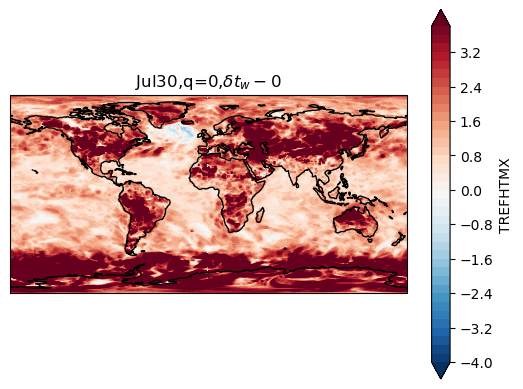

In [44]:
%%time
#Quantile q=0.1
#Plot 3a
levs    = np.arange(-4,4,0.2)
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_jja_diff.sel(quantile=0).sel(day=211).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Jul30,q=0,'+r'$\delta t_w - 0$')

CPU times: user 25.3 s, sys: 2.52 s, total: 27.8 s
Wall time: 34.1 s


Text(0.5, 1.0, 'Jul30, q=0,$\\delta t_{mc}$')

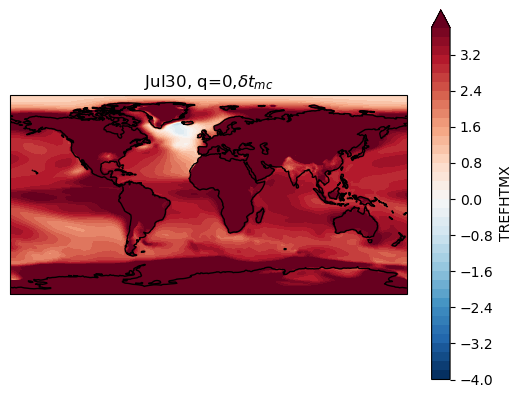

In [39]:
%%time
#PLot 3check
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmc_jja_diff.sel(quantile=0,day=211).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Jul30, q=0,'+r'$\delta t_{mc}$')

CPU times: user 2min 6s, sys: 12 s, total: 2min 18s
Wall time: 2min 43s


Text(0.5, 1.0, 'Jul30, q=0,$\\delta t_w - \\delta t_{mc}$')

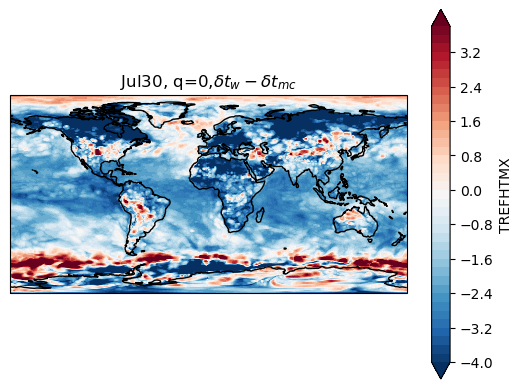

In [40]:
%%time
#PLot 3b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_jja_reldiff1.sel(quantile=0,day=211).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Jul30, q=0,'+r'$\delta t_w - \delta t_{mc}$')

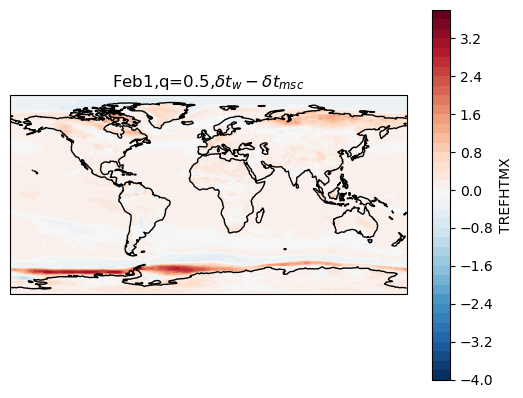

CPU times: user 1min 10s, sys: 6.76 s, total: 1min 16s
Wall time: 1min 31s


In [41]:
%%time
#PLot 3c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_jja_reldiff2.sel(quantile=0.5,day=211).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Feb1,q=0.5,'+r'$\delta t_w - \delta t_{msc}$')
plt.show()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

CPU times: user 1min 39s, sys: 5.56 s, total: 1min 44s
Wall time: 1min 55s


Text(0.5, 1.0, 'q=0.9,$\\delta t_w - 0$,JJA mean')

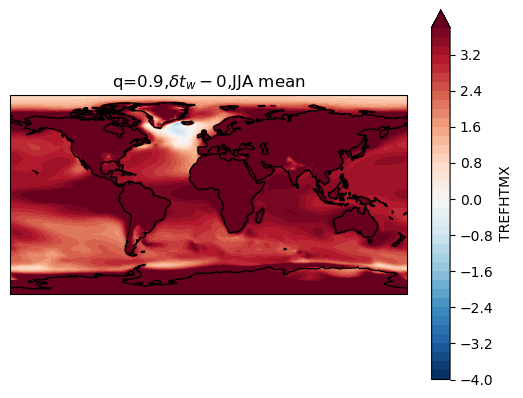

In [42]:
%%time
#Quantile q=0.1
#Plot 3a
levs    = np.arange(-4,4,0.2)
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_jja_diff.sel(quantile=0.9).mean('day').plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('q=0.9,'+r'$\delta t_w - 0$,'+season+' mean')

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

CPU times: user 2min 9s, sys: 7.11 s, total: 2min 16s
Wall time: 2min 13s


Text(0.5, 1.0, 'q=0.1,$\\delta t_w - \\delta t_{mc}$,JJA mean')

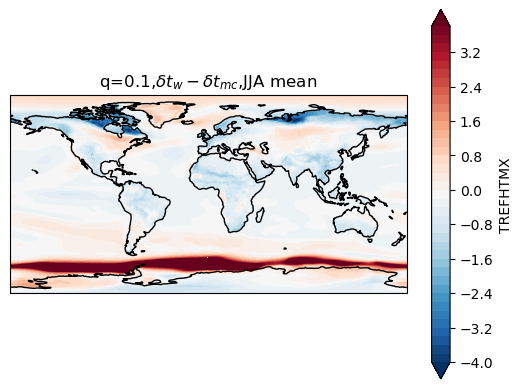

In [43]:
%%time
#PLot 3b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_jja_reldiff1.sel(quantile=0.1).mean('day').plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('q=0.1,'+r'$\delta t_w - \delta t_{mc}$,'+season+' mean')

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

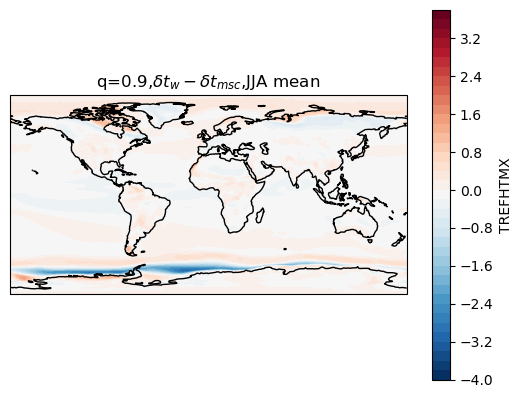

CPU times: user 2min 9s, sys: 6.69 s, total: 2min 16s
Wall time: 2min 12s


In [44]:
%%time
#PLot 3c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_jja_reldiff2.sel(quantile=0.9).mean('day').plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$,'+season+' mean')
plt.show()

In [45]:
############# Compute area-weighted mean square of the above errors #####################

In [46]:
qgmw_jja_esq  = qgmw_jja_diff**2
qgmc_jja_esq  = qgmw_jja_reldiff1**2
qgmsc_jja_esq = qgmw_jja_reldiff2**2

In [47]:
weights      = np.cos(np.deg2rad(qgmw_jja_esq.lat))
weights.name = "weights"

In [48]:
qgmw_jjaserror_weighted  = qgmw_jja_esq.weighted(weights)
qgmc_jjaserror_weighted  = qgmc_jja_esq.weighted(weights)
qgmsc_jjaserror_weighted = qgmsc_jja_esq.weighted(weights)
qgmc_jja_esq

,Array,Chunk
Bytes,3.83 GiB,2.31 MiB
Shape,"(101, 192, 288, 92)","(101, 20, 30, 5)"
Count,19002 Tasks,1900 Chunks
Type,float64,numpy.ndarray


In [49]:
qgmw_jjaserror_gmean   = qgmw_jjaserror_weighted.mean({'lat','lon'})
qgmc_jjaserror_gmean   = qgmc_jjaserror_weighted.mean({'lat','lon'})
qgmsc_jjaserror_gmean  = qgmsc_jjaserror_weighted.mean({'lat','lon'})
qgmc_jjaserror_gmean

<xarray.DataArray 'TREFHTMX' (quantile: 101, day: 92)>
dask.array<truediv, shape=(101, 92), dtype=float64, chunksize=(101, 5), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [50]:
qgmw_jja_gmse   = qgmw_jjaserror_gmean.mean({'day'})
qgmc_jja_gmse   = qgmc_jjaserror_gmean.mean({'day'})
qgmsc_jja_gmse  = qgmsc_jjaserror_gmean.mean({'day'})
qgmc_jja_gmse

<xarray.DataArray 'TREFHTMX' (quantile: 101)>
dask.array<mean_agg-aggregate, shape=(101,), dtype=float64, chunksize=(101,), chunktype=numpy.ndarray>
Coordinates:
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [51]:
%%time
qgmw_jja_grmse         = np.sqrt(qgmw_jja_gmse)
qgmc_jja_grmse         = np.sqrt(qgmc_jja_gmse)
qgmsc_jja_grmse        = np.sqrt(qgmsc_jja_gmse)

CPU times: user 21.3 ms, sys: 2.96 ms, total: 24.3 ms
Wall time: 20.2 ms


In [52]:
%%time
qgmw_jja_grmsepath  = cvals+'qgmw_jja_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_jja_grmsepath  = cvals+'qgmc_jja_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_jja_grmsepath = cvals+'qgmsc_jja_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##########################

CPU times: user 0 ns, sys: 35 µs, total: 35 µs
Wall time: 52.7 µs


In [53]:
%%time
qgmw_jja_grmse   = xr.open_zarr(qgmw_jja_grmsepath)
qgmc_jja_grmse   = xr.open_zarr(qgmc_jja_grmsepath)
qgmsc_jja_grmse  = xr.open_zarr(qgmsc_jja_grmsepath)
qgmw_jja_grmse   = qgmw_jja_grmse.TREFHTMX
qgmc_jja_grmse   = qgmc_jja_grmse.TREFHTMX
qgmsc_jja_grmse  = qgmsc_jja_grmse.TREFHTMX

CPU times: user 142 ms, sys: 30.1 ms, total: 172 ms
Wall time: 326 ms


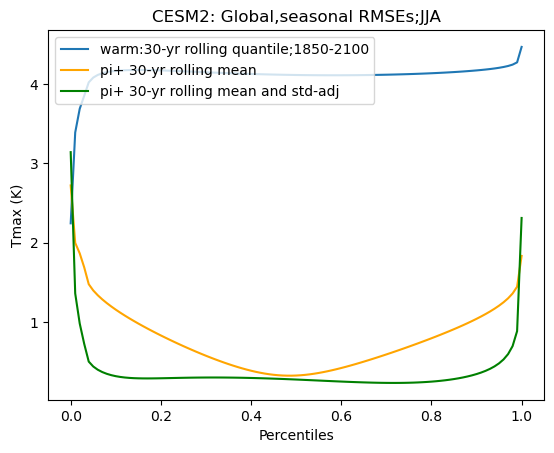

CPU times: user 2.31 s, sys: 211 ms, total: 2.52 s
Wall time: 2.47 s


In [54]:
%%time
plt.plot(quants,qgmw_jja_grmse,label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
plt.plot(quants,qgmc_jja_grmse,label='pi+ 30-yr rolling mean',c='orange')
plt.plot(quants,qgmsc_jja_grmse,label='pi+ 30-yr rolling mean and std-adj',c='g')
plt.legend(loc='upper left')
plt.title('CESM2: Global,seasonal RMSEs;'+season)
plt.ylabel('Tmax (K)')
plt.xlabel('Percentiles')
plt.show()

In [55]:
%%time
JJA_error_redn = qgmsc_jja_grmse.integrate('quantile')/qgmc_jja_grmse.integrate('quantile')
JJA_error_redn.values

CPU times: user 436 ms, sys: 36.4 ms, total: 472 ms
Wall time: 484 ms


array(0.45678986)

In [59]:
qgmsc_jja_grmse.where(qgmsc_jja_grmse<0.5).values

array([       nan,        nan,        nan,        nan,        nan,
       0.44120671, 0.40068489, 0.37126378, 0.34902697, 0.33208757,
       0.31922936, 0.30960554, 0.30257254, 0.2976094 , 0.29432937,
       0.29233247, 0.29131117, 0.29103365, 0.29135183, 0.29205263,
       0.2930405 , 0.29418083, 0.29540794, 0.29663557, 0.29782184,
       0.29894673, 0.29994698, 0.30082887, 0.3015228 , 0.3020651 ,
       0.30244459, 0.30265666, 0.30270047, 0.30254687, 0.30219885,
       0.30169973, 0.30105192, 0.30022306, 0.29924449, 0.29809898,
       0.29679602, 0.29536065, 0.29378246, 0.29205283, 0.29023241,
       0.28827658, 0.28622706, 0.28407595, 0.28182154, 0.27946201,
       0.277038  , 0.27456359, 0.27203329, 0.26947358, 0.2668959 ,
       0.26428584, 0.26169541, 0.2591193 , 0.25655794, 0.2540539 ,
       0.25161518, 0.24925743, 0.2470071 , 0.24485006, 0.24285002,
       0.24098375, 0.23931015, 0.23781669, 0.23655843, 0.23555194,
       0.23483673, 0.23444136, 0.23437767, 0.23469783, 0.23540

In [58]:
qgmsc_jja_grmse.where(qgmsc_jja_grmse<1).values

array([       nan,        nan, 0.98283541, 0.72554536, 0.50296053,
       0.44120671, 0.40068489, 0.37126378, 0.34902697, 0.33208757,
       0.31922936, 0.30960554, 0.30257254, 0.2976094 , 0.29432937,
       0.29233247, 0.29131117, 0.29103365, 0.29135183, 0.29205263,
       0.2930405 , 0.29418083, 0.29540794, 0.29663557, 0.29782184,
       0.29894673, 0.29994698, 0.30082887, 0.3015228 , 0.3020651 ,
       0.30244459, 0.30265666, 0.30270047, 0.30254687, 0.30219885,
       0.30169973, 0.30105192, 0.30022306, 0.29924449, 0.29809898,
       0.29679602, 0.29536065, 0.29378246, 0.29205283, 0.29023241,
       0.28827658, 0.28622706, 0.28407595, 0.28182154, 0.27946201,
       0.277038  , 0.27456359, 0.27203329, 0.26947358, 0.2668959 ,
       0.26428584, 0.26169541, 0.2591193 , 0.25655794, 0.2540539 ,
       0.25161518, 0.24925743, 0.2470071 , 0.24485006, 0.24285002,
       0.24098375, 0.23931015, 0.23781669, 0.23655843, 0.23555194,
       0.23483673, 0.23444136, 0.23437767, 0.23469783, 0.23540